# TP6.6 - Construire des modèles complexes (Approche fonctionnelle)

Keras propose une API qui permet de construire des modèles de DNN complexe en se basant sur une modélisation fonctionnelle.</br>
Le modèle fonctionnelle est assez simple à appréhender, on l'écrit comme une fonction mathématique:

$ x=tf.keras.layers.Input(10), y=f(x); z=(g(y); u=concat(f(x),g(y))$</br>
Prenons par exemple le modèle: la couche de normalisation est concaténée avec la couche hidden 2.
<figure>
    <img src="../images/functionalModel.jpg"  style="width:240px;height:300px;" >
</figure>

input_ = tf.keras.layers.Input(X_train.shape[1])</br>
normalized_input = tf.keras.layers.Normalization()(input_)</br>
hidden1 = tf.keras.layers.Dense(????, activation="???")(normalized_input)</br>
hidden2 = tf.keras.layers.Dense(????, activation="????")(hidden1)</br>
concat = tf.keras.layers.Concatenate()([normalized_input, hidden2])</br>
output = tf.keras.layers.Dense(1, activation="sigmoid")(concat)</br>



model = tf.keras.Model(inputs=[input_], outputs=[output])</br></br>



On peut construire aisément des architectures sophistiquées. 
- On peut imaginer par exemple que les hidden couches 1 et 2 sont concaténées. 
- la Hidden 1 est remise à la sortie de hidden 1. 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [8]:
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    # Define the true positives, false positives and false negatives
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    # Calculate the precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calculate the F1 score
    f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    return f1_score

## Réseaux de neurones avec une sortie sigmoide  sigmoïde


### 1 Le DataSet
On utilisera le Dataset smoking, 

In [9]:
# Lecture du dataset n permet de limiter le nombre de lignes à lire
# Pour faciliter les tests
import pandas as pd
def load_data(n):
    data = pd.read_csv('../../data/train.csv')
    return data[0:n]

def select_variables(data):
    data.dropna(axis=0, inplace=True)
    y = data['smoking'] # récupérer la colonne survived et la mettre dans y
    # récuperer le reste des données dans X utiliser la fonction titanic.drop ???, ??? )
    X = data.drop('smoking', axis=1)
    return X,y



## 2 Préparation des données

#### 2.1. Split des données 

In [10]:
def split_data(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test  

In [11]:
## On peut utiliser une simple normalisation (x-mu)/ecart type)
def normaliser(X_train, X_test):
    mean = X_train.mean()
    std  = X_train.std()
    X_train = (X_train - mean) / std
    X_test  = (X_test  - mean) / std

    return X_train, X_test 

In [12]:
# Préparation ds données
# le -1 du load_data(-1) veut dire on prend toutes les lignes 
data=load_data(-1)
# sélectionner les variables
X,y = select_variables(data)
X_train, X_test, y_train, y_test = split_data(X,y)
X_train, X_test = normaliser(X_train, X_test)
print("X_train.shape", X_train.shape, "X_test.shape", X_test.shape)

X_train.shape (127404, 23) X_test.shape (31851, 23)


## 3. Définition du modèle de régression linaire

On définit un modèle avec deux branches
- une branche : une réseau à 2 couches  à 50 neurones avec un relu
- une branche : un réseau 

#### 3.1 Un réseau de neurones complexe à plusieurs couches

In [14]:

input_ = tf.keras.layers.Input(X_train.shape[1])
normalized_input = tf.keras.layers.Normalization()(input_)
hidden1 = tf.keras.layers.Dense(50, activation="relu")(normalized_input) # on normalise les données
hidden2 = tf.keras.layers.Dense(50, activation="relu")(hidden1) # couche cachée avec 50 neurones
concat = tf.keras.layers.Concatenate()([normalized_input, hidden2]) # on concatène les deux couches
output = tf.keras.layers.Dense(1, activation="sigmoid")(concat) # couche de sortie avec une sigmoide
#Compiler le modèle
model = tf.keras.Model(inputs=[input_], outputs=[output])
model.compile(optimizer='adam',
              loss= 'BinaryCrossentropy',
              metrics=['accuracy'])
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 23)]                 0         []                            
                                                                                                  
 normalization (Normalizati  (None, 23)                   47        ['input_1[0][0]']             
 on)                                                                                              
                                                                                                  
 dense (Dense)               (None, 50)                   1200      ['normalization[0][0]']       
                                                                                                  
 dense_1 (Dense)             (None, 50)                   2550      ['dense[0][0]']          

### 4. Entrainement du modèle (Model training)

In [15]:
# Entrainement du modele
history  = model.fit(X_train, 
                     y_train, 
                     epochs=10, 
                     batch_size= 10, 
                     verbose=False,
                     validation_data = (X_test, y_test))
#model.metrics_names

### 5. Evaluation des performances du modèle 
Utilisation de  MAE = Mean Absolute Error (between the labels and predictions), 
la loss, le R2 score 


In [16]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss     :', score[0])
print('Test accuracy :', score[1])
#print('Test f1 score :', score[2])

Test loss     : 0.4597720801830292
Test accuracy : 0.771561324596405


### Historique du Training (training history)
Quel était le meilleur résultat prendant l'entrainement

In [17]:
print(history.params)
print(history.history.keys())
#print(history.history['loss'])

{'verbose': False, 'epochs': 10, 'steps': 12741}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [18]:
import pandas as pd 
df=pd.DataFrame(data=history.history)
display(df)

,loss,accuracy,val_loss,val_accuracy
0,0.466360,0.766569,0.462785,0.769144
1,0.456404,0.772440,0.460063,0.769050
2,0.453644,0.773838,0.464390,0.767888
3,0.451551,0.775996,0.459018,0.770714
4,0.450497,0.775855,0.459491,0.772346
5,0.449826,0.776805,0.459940,0.771342
6,0.448620,0.777370,0.458441,0.772032
7,0.447600,0.778594,0.456999,0.774230
8,0.447028,0.779175,0.458167,0.772126
9,0.446066,0.778735,0.459772,0.771561


Text(0.5, 1.0, 'Accuracy ')

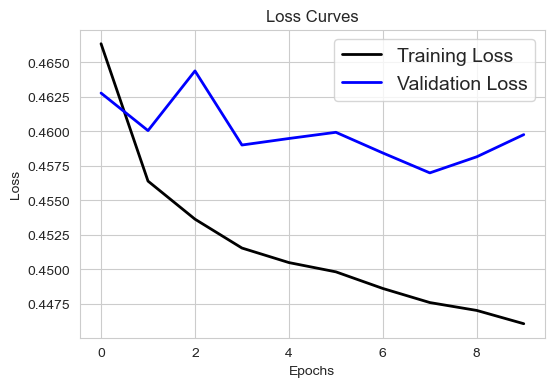

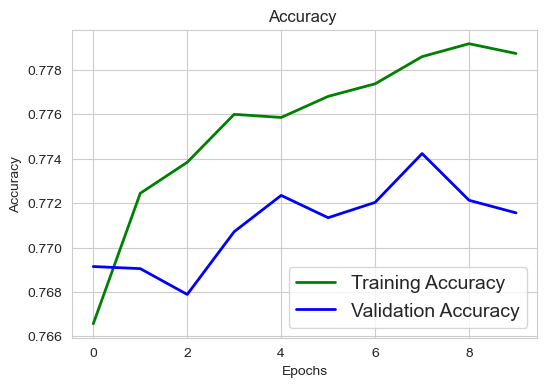

In [23]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

# Plotting the Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'green', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy ', fontsize=12)


996/996 [==============================] - 1s 671us/step


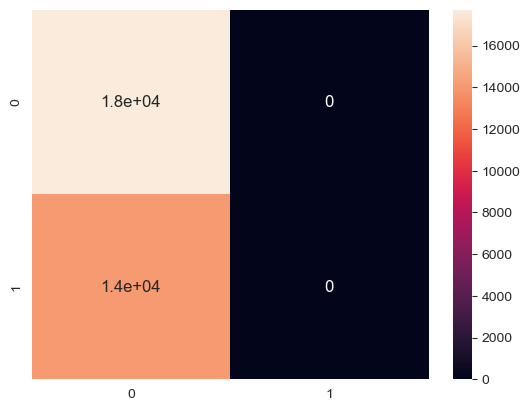

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(X_test)

# Predict probabilities
y_pred = model.predict(X_test)

# Get class labels
y_classes = np.argmax(y_pred, axis=-1)
#y_classes = np.where(predictions > 0.5, 1, 0)

cm = confusion_matrix(y_test, y_classes)
#disp= ConfusionMatrixDisplay(confusion_matrix=cm)

sns.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()


### Save History and model

In [27]:
#Saving:

np.save('my_history_sd_1n.npy',history.history)
#np.save('my_history_sd_MLP.npy',history.history)
#np.save('my_history_Ld_1n.npy',history.history)
#np.save('my_history_Ld_MLP.npy',history.history)

In [35]:
#Loading:
# utiliser les chemins absolus avec os
import os
os.getcwd()
path = os.getcwd()
# chemin du fichier my_history.npy = C:\Users\Baran\OneDrive\Bureau\TP 3e année\IA\Deep Learning\TP6\my_history_sd_1n.npy
# comment faire pour que path soit le chemin du fichier my_history.npy
path = os.path.join(path, 'my_history_sd_1n.npy.npy')
history=np.load(path,allow_pickle='TRUE').item()


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Baran\\OneDrive\\Bureau\\TP 3e année\\IA\\Deep Learning\\TP6\\my_history_sd_1n.npy.npy'

### 6. Faire des prédictions

In [ ]:
#Small Sata set
my_data = [ -0.25, -0.75, 0.78]
survived = 0
my_data=np.array(my_data).reshape(1,3)


In [ ]:
predictions = model.predict( my_data )
print("Prediction : {:.2f} K$".format(predictions[0][0]))
print("Reality    : {:.2f} K$".format(survived))


## Question:
- Comparer les deux modèles (simple versus complexe)